# Importy

In [3]:
import pandas as pd
from IPython.display import display

# APICommunication
import APICommunication.config as cfg

# Data
from Data.DataLoader import *
from Data.DataCleaner import *

# MarkowitzAnalysis
from MarkowitzAnalysis.ReturnAnalysis import *

# PortfolioAnalysis
from PortfolioAnalysis.PortfolioPerformance import *
from PortfolioAnalysis.PortfolioLoader import *

# PositionAnalysis
from PositionAnalysis.PositionManipulations import *

# Plotting
from Plotting.Plotter import *
from Plotting.EfficientFrontierPlot import *

# Backtest
from Backtest.Backtest import *

from warnings import filterwarnings
filterwarnings('ignore')

# Działanie właściwego programu

## Scenariusz 0. Aktualizacja danych do obecnej daty

In [1]:
start = '2025-01-25'

print(f"[INFO] Rozpoczynam pracę programu: {now(False)}")

dataloader = DataLoader(cfg.user_id, cfg.pwd)
data = dataloader.loadInstrumentsData(start)

NameError: name 'now' is not defined

## Scenariusz 1. Analiza obecnej pozycji przez łączenie z API

In [2]:
print(f"[INFO] Rozpoczynam pracę programu: {now(False)}")

dl = DataLoader(cfg.user_id, cfg.pwd)
info = dl.loadInstrumentsInfo()

pm = PositionManipulator(cfg.user_id, 
                         cfg.pwd, 
                         info=info,
                         filename_load='Pozycja od 10.12.2024 do 10.03.2025',
                         filepath_load='Positions')
pa = pm.AnalyzePosition()

display(pa.getSummary())

print(f"Zwrot z portfela: {pa.getPCTReturn()}%")
print(f"Zysk z inwestycji: {pa.getPLNReturn()} PLN")

[INFO] Rozpoczynam pracę programu: 2025-02-04 19:46:12


,P500.DE,FLXI.DE,4GLD.DE,ESD.FR
CzasOtwarcia,2024-12-10 15:50:41,2024-12-10 15:51:14,2024-12-10 15:52:16,2024-12-10 15:51:46
WartoscPoczatkowaPLN,389.79,539.99,210.0,58.99
CenaOtwarcia,1134.05,43.55,82.2,24.307
CenaAktualna,1147.9,40.95,88.005,24.101
Zwrot [%],1.221287,-5.970149,7.062044,-0.847492
KursWalutowyOtwarcia,4.281605,4.281605,4.281605,4.077424
KursWalutowyAktualny,4.187955,4.187955,4.187955,4.031939
ZwrotWalutowy [%],-2.187264,-2.187264,-2.187264,-1.115533
CenaOtwarciaPLN,4855.55415,186.463898,351.947931,99.109945
CenaAktualnaPLN,4807.353544,171.496757,368.56098,97.173762


Zwrot z portfela: -3.21%
Zysk z inwestycji: -38.45 PLN


## Scenariusz 2. Wybór nowej pozycji

In [3]:
start, end = '2023-09-01', '2025-02-03'

print(f"[INFO] Rozpoczynam pracę programu: {now(False)}")

dataloader = DataLoader(cfg.user_id, cfg.pwd)
data = dataloader.loadInstrumentsData(start, end)
info = dataloader.loadInstrumentsInfo()

datacleaner = DataCleaner(data, info, verbose=False)

freq = '6M'
returnRates = datacleaner.getReturnRates(freq)
mo = MarkowitzOptimization(returnRates, freq)
mo.getOptimalWeights(model='max_sharpe', risk_method='oas')
portfolio = mo.getPortfolio()

# Możemy zapoznać się ze statystykami zaproponowanej pozycji
print()
portfolio.getSummary()

[INFO] Rozpoczynam pracę programu: 2025-02-04 19:48:08
[INFO] Załadowano 829 instrumentów.

Opis wygenerowany 2025-02-04 19:48:35.
Okres inwestycji: 6M.
Zastosowane kryterium wyboru: max_sharpe.
Metoda estymacji ryzyka: oas.
Poziom ufności: 0.95.
Oczekiwany zwrot z portfela [%]: 12.1987
Oczekiwane ryzyko portfela [%]: 2.3699
Przedział ufności dla stóp zwrotu [%]: [7.5848, 15.3034]
Sharpe Ratio portfela: 3.8764
Skład portfela:
	SPYL.DE:
		Waga w portfelu [%]: 2.974
		Oczekiwana stopa zwrotu [%]: 11.5173
		Oczekiwana stopa ryzyka [%]: 4.1385
		Przedział ufności dla stóp zwrotu [%]: [4.6112, 17.7791]
	XWEU.DE:
		Waga w portfelu [%]: 2.535
		Oczekiwana stopa zwrotu [%]: 8.6327
		Oczekiwana stopa ryzyka [%]: 3.4256
		Przedział ufności dla stóp zwrotu [%]: [3.4894, 13.5868]
	WELK.DE:
		Waga w portfelu [%]: 1.879
		Oczekiwana stopa zwrotu [%]: 13.3775
		Oczekiwana stopa ryzyka [%]: 4.4079
		Przedział ufności dla stóp zwrotu [%]: [6.4489, 19.7576]
	XDWF.DE:
		Waga w portfelu [%]: 3.364
		Oczek

#### Scenariusz 2a. Statystyki nas zainteresowały i chcemy zapisać rekomendację na później.

In [ ]:
portfolio.getSummary(save_dict=True, filename='pos1', filepath='Recommendations')

#### Scenariusz 2b. Chcemy przekalkulować skład portfela na PLN z zapisanej wcześniej rekomendacji.

In [3]:
K = 1200 # kwota do wpłacenia

pm = PositionManipulator(cfg.user_id, 
                         cfg.pwd, 
                         info = info, 
                         filename_load = 'pos1', 
                         filepath_load = 'Recommendations')
pm.Recalculate(K)

Skład portfela przeliczony dla kwoty 1200 PLN:
	SPYL.DE: 35.69 PLN
	XWEU.DE: 30.42 PLN
	WELK.DE: 22.55 PLN
	XDWF.DE: 40.37 PLN
	LIRU.DE: 151.60 PLN
	LYPD.DE: 18.74 PLN
	4GLD.DE: 198.95 PLN
	ZPDF.DE: 111.71 PLN
	EGLN.UK: 185.70 PLN
	IGLN.UK: 105.46 PLN
	LYBK.DE: 31.43 PLN
	BNKE.FR: 58.22 PLN
	2B7A.DE: 13.92 PLN
	XAIX.DE: 94.69 PLN
	XREA.DE: 83.46 PLN


#### Scenariusz 2c. Chcemy otwierać pozycję zapisaną w rekomendacji.

In [10]:
K = ... # kwota do wpłacenia
filename_load = ... # nazwa pliku z rekomendacją
position_start = ... # data dzienna otwarcia pozycji
position_end = ... # data dzienna zamknięcia pozycji (patrzymy na 'freq')

pm = PositionManipulator(cfg.user_id, 
                         cfg.pwd, 
                         info = info, 
                         filename_load = filename_load, 
                         filepath_load = 'Recommendations')
pm.Recalculate(K)
pm.OpenPosition(filename_save=f'Pozycja od {position_start} do {position_end}')

Skład portfela przeliczony dla kwoty 1200 PLN:
	DSB.FR: 23.59 PLN
	UBF6.DE: 68.76 PLN
	4GLD.DE: 132.76 PLN
	EGLN.UK: 132.07 PLN
	IGLN.UK: 33.85 PLN
	XCS5.DE: 73.44 PLN
	2B7A.DE: 122.34 PLN
	ZPDU.DE: 133.98 PLN
	XCHA.DE: 43.97 PLN
	ZPRP.DE: 36.01 PLN
	ZPDD.DE: 140.50 PLN
	X7PS.DE: 44.12 PLN
	BNKE.FR: 43.78 PLN
	S7XE.DE: 143.23 PLN


## Scenariusz 3. Analiza konkretnego portfela

#### Wariant 1. Podajemy dane ręcznie

In [4]:
print(f"[INFO] Rozpoczynam pracę programu: {now(False)}")

portfolio = {'P500.DE': 32.56, 
             '4GLD.DE': 17.47, 
             'FLXI.DE': 45.06, 
             'ESD.FR': 4.91}

start, end = '2023-07-01', '2024-12-10'
freq = '3M'

dataloader = DataLoader(cfg.user_id, cfg.pwd)
data = dataloader.loadInstrumentsData(start, end)
info = dataloader.loadInstrumentsInfo()

datacleaner = DataCleaner(data, info, load_only=list(portfolio.keys()))
data = datacleaner.getBidPrice()
returnRates = datacleaner.getReturnRates(freq)
pp = PortfolioPerformance(portfolio, returnRates, freq, 'empirical', 'max_utility', data=data)
pp.getSummary()

[INFO] Rozpoczynam pracę programu: 2025-02-04 19:25:46
Opis wygenerowany 2025-02-04 19:25:49.
Okres inwestycji: 3M.
Zastosowane kryterium wyboru: max_utility.
Metoda estymacji ryzyka: empirical.
Poziom ufności: 0.95.
Oczekiwany zwrot z portfela [%]: 4.2758
Oczekiwane ryzyko portfela [%]: 3.5579
Przedział ufności dla stóp zwrotu [%]: [-1.7162, 9.4981]
Sharpe Ratio portfela: 0.7785
Skład portfela:
	P500.DE:
		Waga w portfelu [%]: 32.56
		Oczekiwana stopa zwrotu [%]: 4.4198
		Oczekiwana stopa ryzyka [%]: 5.1972
		Przedział ufności dla stóp zwrotu [%]: [-3.5222, 12.9911]
	4GLD.DE:
		Waga w portfelu [%]: 17.47
		Oczekiwana stopa zwrotu [%]: 5.2874
		Oczekiwana stopa ryzyka [%]: 5.9741
		Przedział ufności dla stóp zwrotu [%]: [-3.5286, 15.3498]
	FLXI.DE:
		Waga w portfelu [%]: 45.06
		Oczekiwana stopa zwrotu [%]: 3.8323
		Oczekiwana stopa ryzyka [%]: 4.5678
		Przedział ufności dla stóp zwrotu [%]: [-2.1775, 12.029]
	ESD.FR:
		Waga w portfelu [%]: 4.91
		Oczekiwana stopa zwrotu [%]: 3.7925
		

##### Wariant 1a. Chcemy zapisać statystyki portfela na później.

In [ ]:
SaveDict(pp.getStatDict(), 'Pozycja od 10.12.2024 do 10.03.2025', 'Positions')

#### Wariant 2. Ładujemy zapisany wcześniej portfel/pozycję/rekomendację.

In [3]:
print(f"[INFO] Rozpoczynam pracę programu: {now(False)}")

start, end = '2024-01-01', '2025-02-03'
pl = PortfolioLoader('Pozycja od 10.12.2024 do 10.03.2025')
pl.getSummary()

[INFO] Rozpoczynam pracę programu: 2025-02-04 19:56:49
Opis wygenerowany 2025-02-04 19:31:34.
Okres inwestycji: 3M.
Zastosowane kryterium wyboru: max_utility.
Metoda estymacji ryzyka: empirical.
Poziom ufności: 0.95.
Oczekiwany zwrot z portfela [%]: 4.2758
Oczekiwane ryzyko portfela [%]: 3.5579
Przedział ufności dla stóp zwrotu [%]: [-1.7162, 9.4981]
Sharpe Ratio portfela: 0.7785
Skład portfela:
	P500.DE:
		Waga w portfelu [%]: 32.56
		Oczekiwana stopa zwrotu [%]: 4.4198
		Oczekiwana stopa ryzyka [%]: 5.1972
		Przedział ufności dla stóp zwrotu [%]: [-3.5222, 12.9911]
	4GLD.DE:
		Waga w portfelu [%]: 17.47
		Oczekiwana stopa zwrotu [%]: 5.2874
		Oczekiwana stopa ryzyka [%]: 5.9741
		Przedział ufności dla stóp zwrotu [%]: [-3.5286, 15.3498]
	FLXI.DE:
		Waga w portfelu [%]: 45.06
		Oczekiwana stopa zwrotu [%]: 3.8323
		Oczekiwana stopa ryzyka [%]: 4.5678
		Przedział ufności dla stóp zwrotu [%]: [-2.1775, 12.029]
	ESD.FR:
		Waga w portfelu [%]: 4.91
		Oczekiwana stopa zwrotu [%]: 3.7925
		

##### Wariant 2a. Poddajemy ten portfel/pozycję/rekomendację dalszej analizie

In [4]:
dataloader = DataLoader(cfg.user_id, cfg.pwd)
data = dataloader.loadInstrumentsData(start, end)
info = dataloader.loadInstrumentsInfo()

datacleaner = DataCleaner(data, info, load_only=pl.symbols)
data = datacleaner.getBidPrice()
returnRates = datacleaner.getReturnRates(pl.freq)

pp = pl.getPortfolio(returnRates, data)
# z obiektu 'pp' można teraz odzyskać historyczny kurs portfela, stopy zwrotu, ryzyko itp.

## Scenariusz 4. Wykresy dla konkretnego portfela

[INFO] Rozpoczynam pracę programu: 2025-02-04 19:59:14

[INFO] Wygładzamy dane, obliczamy zmienność...
[INFO] Rysujemy wykresy...


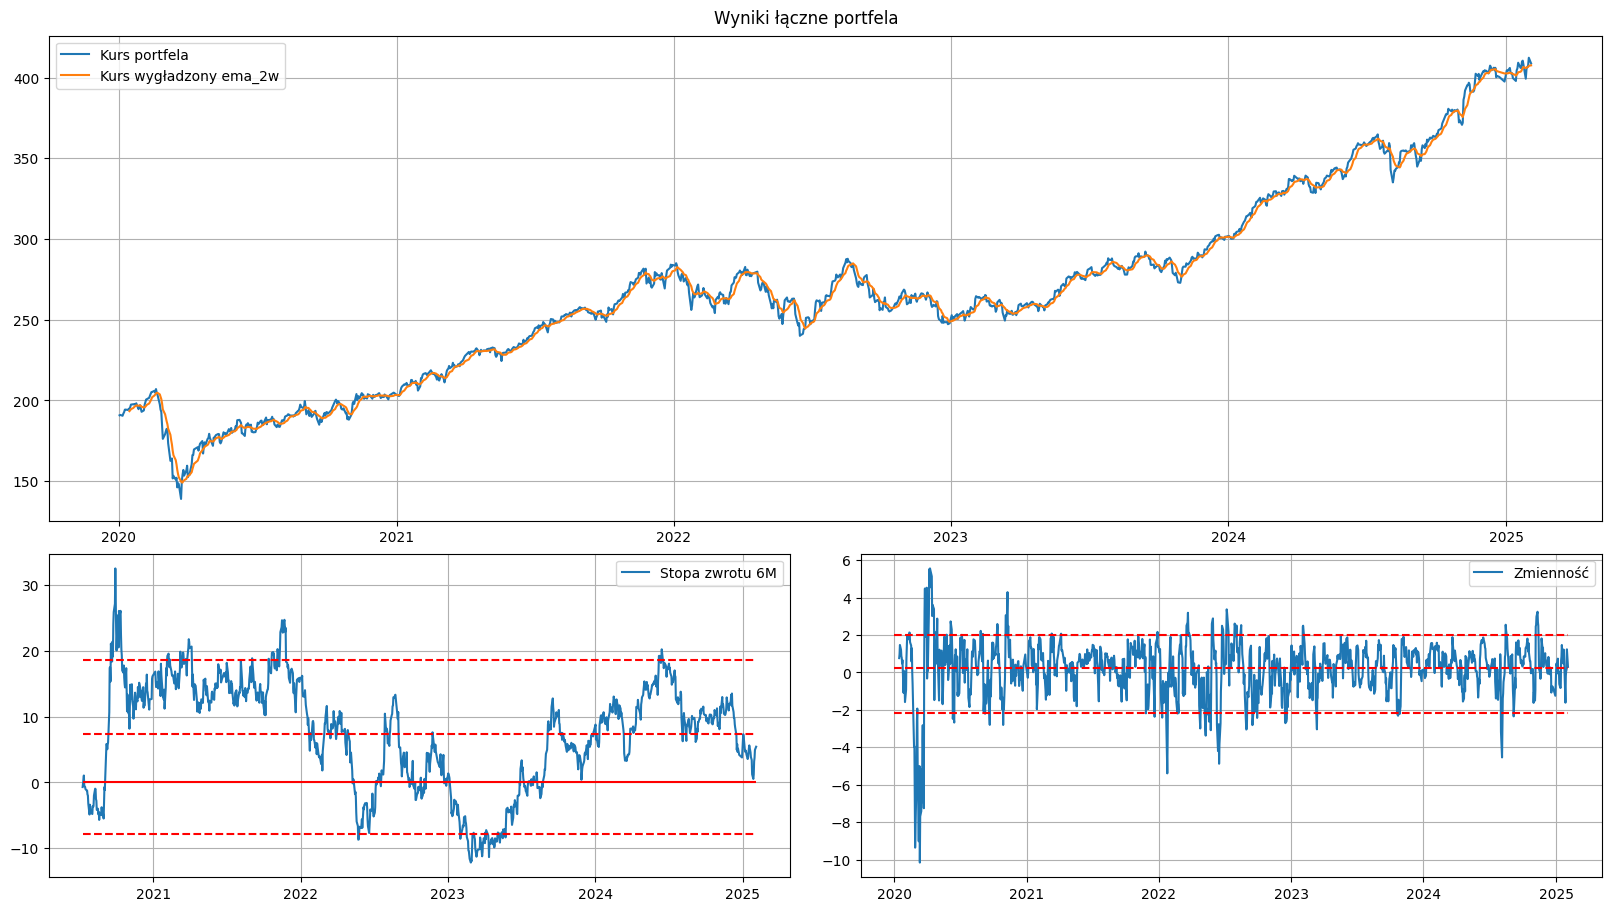

In [7]:
print(f"[INFO] Rozpoczynam pracę programu: {now(False)}")

pl = PortfolioLoader('Pozycja od 10.12.2024 do 10.03.2025')
freq = '6M' # można to pobrać z obiektu 'pl' jako 'pl.freq', ale można też ustawić na inną wartość

# print()
# pl.getSummary()

print()
start, end = '2020-01-01', '2025-02-03'
dataloader = DataLoader(cfg.user_id, cfg.pwd)
data = dataloader.loadInstrumentsData(start, end)
info = dataloader.loadInstrumentsInfo()

datacleaner = DataCleaner(data, info, load_only=pl.symbols)
data = datacleaner.getBidPrice()
returnRates = datacleaner.getReturnRates(freq)

plotter = Plotter(pl.portfolio,
                  data,
                  returnRates,
                  freq,
                  pl.model,
                  pl.risk_method,
                  compare='ema_2w')
plotter.plot(show_instruments=False)

## Scenariusz 5. Wykres "Efficient Frontier"

In [3]:
start, end = '2024-01-01', '2025-02-03'

print(f"[INFO] Rozpoczynam pracę programu: {now(False)}")

dataloader = DataLoader(cfg.user_id, cfg.pwd)
data = dataloader.loadInstrumentsData(start, end)
info = dataloader.loadInstrumentsInfo()

datacleaner = DataCleaner(data, info)

[INFO] Rozpoczynam pracę programu: 2025-02-04 18:02:51
[INFO] Usuwanie instrumentów o wysokich kosztach obsługi.
	Aktualizacja danych...
	Pozostawiam 953 instrumentów.
[INFO] Usuwanie instrumentów o wysokich spreadach.
	Aktualizacja danych...
	Pozostawiam 953 instrumentów.
[INFO] Usuwanie instrumentów o dużych brakach w danych.
	Aktualizacja danych...
	Pozostawiam 908 instrumentów.
[INFO] Usuwanie instrumentów na podstawie ich zmienności.
	Aktualizacja danych...
	Pozostawiam 839 instrumentów.


In [4]:
freq = '3M'
returnRates = datacleaner.getReturnRates(freq)
ef = EfficientFrontierPlot(returnRates, freq, Npoints=80)

[INFO] Przygotowuję dane do wykresu...
	Pozostało 100.0%
	Pozostało 87.5%
	Pozostało 75.0%
	Pozostało 62.5%
	Pozostało 50.0%
	Pozostało 37.5%
	Pozostało 25.0%
	Pozostało 12.5%
[INFO] Wyznaczamy portfel 'max_sharpe'...
[INFO] Wyznaczamy portfele 'max_utility'...


[INFO] Generuję 5000 portfeli losowych...
	Pozostało 100.0%
	Pozostało 90.0%
	Pozostało 80.0%
	Pozostało 70.0%
	Pozostało 60.0%
	Pozostało 50.0%
	Pozostało 40.0%
	Pozostało 30.0%
	Pozostało 20.0%
	Pozostało 10.0%
[INFO] Rysuję wykres...


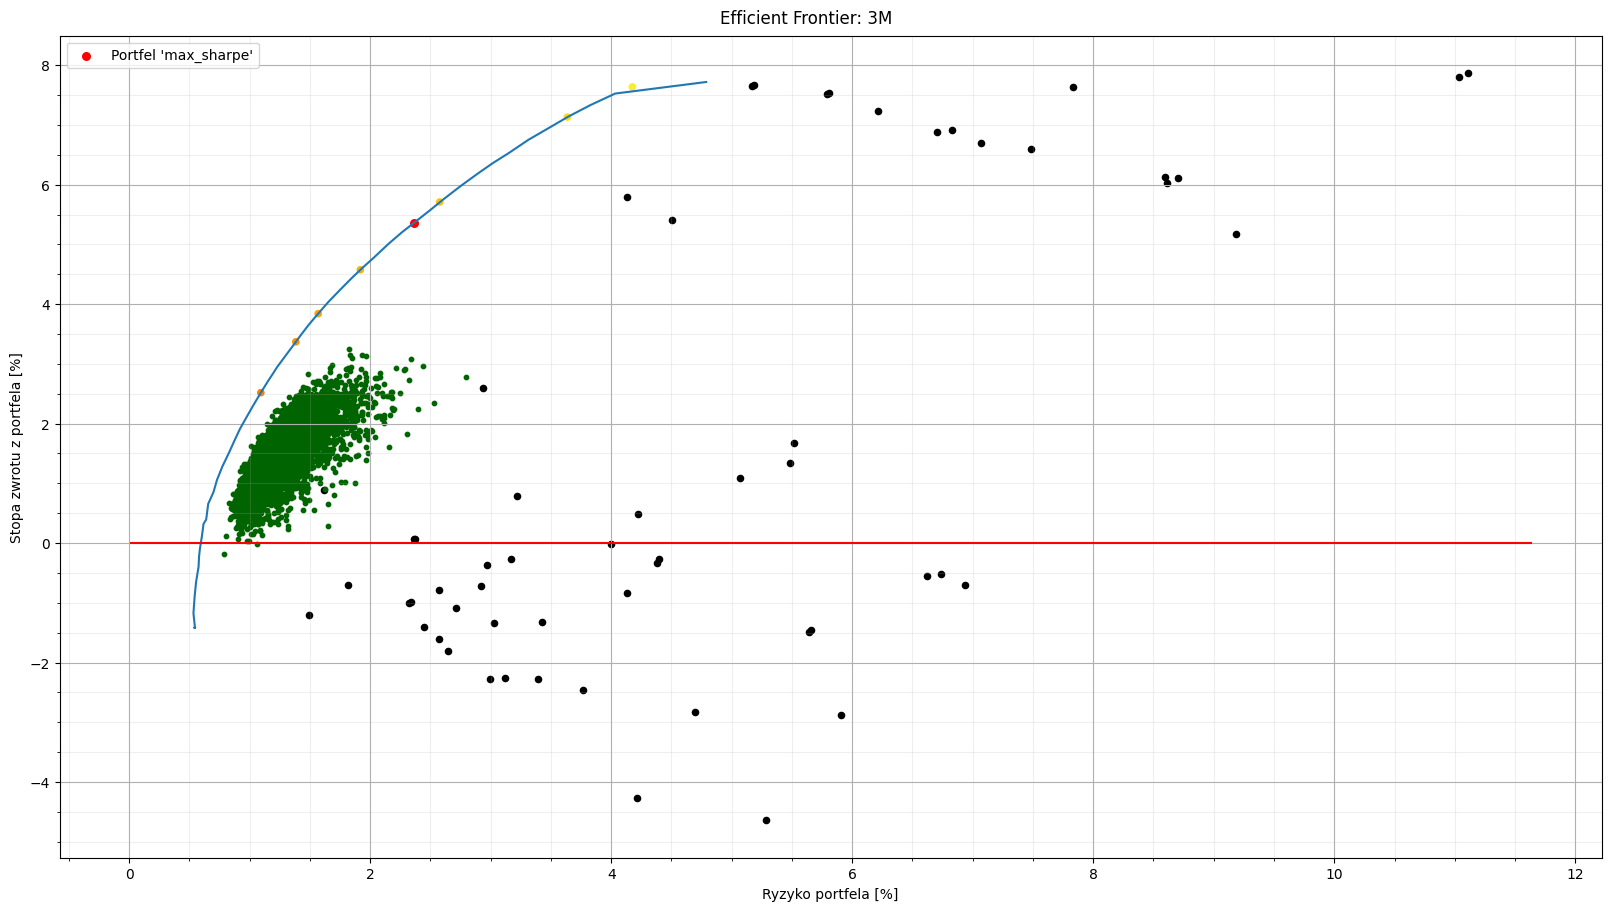

In [5]:
ef.plot(Nrandom=5000)

## Scenariusz 6: Backtest modelu

In [6]:
start, end = '2016-01-01', '2025-02-03'
freq = '6M'

bt = Backtest(start, end, freq, len_train=2)
BacktestSummary = bt.getSummary(success_threshold=2.5,
                                sharpe_threshold=2.0,
                                low_CI_threshold=3.5)

[INFO] Okres 1 z 15. Pobieramy dane od 2016-01-31 do 2018-01-31: 2025-02-04 22:00:41
	[INFO] Trening w okresie od 2016-01-31 do 2017-07-31
	Oczekiwany zwrot treningowy: 10.04%
	Sharpe Ratio: 3.14

	[INFO] Test w okresie od 2017-07-31 do 2018-01-31
	Rzeczywisty zwrot w okresie testowym: 8.04%
	Treningowy przedział ufności: [6.85%, 14.09%]

[INFO] Okres 2 z 15. Pobieramy dane od 2016-07-31 do 2018-07-31: 2025-02-04 22:00:57
	[INFO] Trening w okresie od 2016-07-31 do 2018-01-31
	Oczekiwany zwrot treningowy: 9.51%
	Sharpe Ratio: 3.28

	[INFO] Test w okresie od 2018-01-31 do 2018-07-31
	Rzeczywisty zwrot w okresie testowym: 11.47%
	Treningowy przedział ufności: [6.47%, 12.79%]

[INFO] Okres 3 z 15. Pobieramy dane od 2017-01-31 do 2019-01-31: 2025-02-04 22:01:14
	[INFO] Trening w okresie od 2017-01-31 do 2018-07-31
	Oczekiwany zwrot treningowy: 8.89%
	Sharpe Ratio: 2.42

	[INFO] Test w okresie od 2018-07-31 do 2019-01-31
	Rzeczywisty zwrot w okresie testowym: 4.01%
	Treningowy przedział ufno

OSError: [Errno 22] Invalid argument: 'Data/InstrumentsData1.csv'

In [5]:
BacktestSummary

,ExpectedReturn,ConfIntLow,ConfIntHigh,SharpeRatio,TrueReturn,Error,InConfInt,WasOpened,WasSuccessful
1,4.26,-0.62,9.92,1.015267,3.99,-0.27,True,False,False
2,2.92,-3.95,9.65,0.445924,-3.95,-6.87,True,False,False
3,2.77,-3.93,10.68,0.368932,11.30,8.53,False,False,False
4,2.38,-0.43,5.17,0.717045,3.17,0.79,True,False,False
5,3.15,1.30,5.51,1.686511,2.93,-0.22,True,False,False
6,5.04,2.77,7.33,2.876336,4.71,-0.33,True,True,True
7,2.70,0.39,4.98,1.144812,0.49,-2.21,True,False,False
8,2.93,0.14,5.50,1.175289,2.87,-0.06,True,False,False
9,3.70,-0.64,7.64,0.984208,2.43,-1.27,True,False,False
10,3.96,-0.50,9.65,0.818648,1.86,-2.10,True,False,False


In [7]:
(BacktestSummary['TrueReturn']/BacktestSummary['ExpectedReturn'] - 1)*100

1     -26.833977
2     -55.888651
3    -294.210526
4      -5.376344
5      10.726644
6      22.727273
7      18.181818
8     -92.088608
9      -7.990868
10      1.132075
11    -31.860776
12      0.408163
13     77.415144
14      4.789272
15    -48.756906
16      2.507375
17    -26.666667
18     12.115385
19    -27.373068
20    -87.956204
21     21.356784
22    -23.518164
23    -16.894977
24   -104.897959
25    141.282051
26    -46.849315
27     26.420455
28    -53.346856
29    -99.500000
30    -45.625000
31    -67.574932
32   -121.345708
33    195.845697
34    -39.951574
35    -49.596774
36    -16.786571
37      4.573171
38     14.369501
dtype: float64

# Brudnopis

## Backtest - pierwsze kroki

In [ ]:
# Input:
start, end = '2020-01-01', '2025-01-30'
freq = '3M'

dates = [x.strftime("%Y-%m-%d") for x in pd.date_range(start, end, freq=freq)]
len_train = 4 # to powinno być jakąś funkcją 'freq'
len_train += 1 # stopy zwrotu nie obliczają się dla pierwszego okresu treningowego

######################################################################
train = []
test = []
for i, x in enumerate(dates):
    
    if i+len_train+1 >= len(dates):
        break
    
    start_train = dates[i]
    end_train = dates[i+len_train]
    end_test = dates[i+len_train+1]
    
    train.append((start_train, end_train))
    test.append((end_train, end_test))

assert len(train) == len(test)

######################################################################
summary_dict = {}

for i in range(len(train)):
    
    # Okres treningowy
    start_train, end_train = train[i]
    
    # Okres testowy
    start_test, end_test = test[i]
    
    # Ładujemy całe dane na raz
    dataloader = DataLoader(cfg.user_id, cfg.pwd)
    
    print(f"[INFO] Okres {i+1} z {len(train)}. Pobieramy dane od {start_train} do {end_test}: {now(False)}")
    data = dataloader.loadInstrumentsData(start_train, end_test)
    info = dataloader.loadInstrumentsInfo()
    
    datacleaner = DataCleaner(data, info, verbose=False)
    returnRates = datacleaner.getReturnRates(freq)
    
    # Trening
    print(f"\t[INFO] Trening w okresie od {start_train} do {end_train}")

    train_indices = returnRates.index.isin(pd.date_range(start_train, end_train))
    mo = MarkowitzOptimization(returnRates.loc[train_indices, :], freq, verbose=False)
    mo.getOptimalWeights(model='max_sharpe', risk_method='oas')
    pp = mo.getPortfolio()
    expected_return = pp.portfoliomean
    conf_int = getQuantiles(pp.portfolioReturn, q=0.05)
    sharpe_ratio = pp.sharpe_ratio
    
    print(f"\tOczekiwany zwrot treningowy: {expected_return:.2%}")
    print(f"\tSharpe Ratio: {sharpe_ratio:.2f}")
    print()
    portfolio = pp.portfolio
    
    # Test
    print(f"\t[INFO] Test w okresie od {start_test} do {end_test}")

    test_indices = returnRates.index.isin(pd.date_range(start_train, end_train))
    pp = PortfolioPerformance(portfolio, returnRates.loc[test_indices, :], freq, 'empirical', 'max_utility')
    true_return = pp.portfolioReturn.iloc[-1]
    
    # if sharpe_ratio >= 1.0:
    #     if true_return < conf_int[0]: summary_dict['below'] += 1
    #     elif (true_return >= conf_int[0]) and (true_return < expected_return): summary_dict['lower_half'] += 1
    #     elif (true_return >= expected_return) and (true_return < conf_int[1]): summary_dict['upper_half'] += 1
    #     elif true_return > conf_int[1]: summary_dict['above'] += 1
    #     else: print('Jakiś idiotyczny błąd xd')
    
    print(f"\tRzeczywisty zwrot w okresie testowym: {true_return:.2%}")
    print(f"\tTreningowy przedział ufności: [{conf_int[0]:.2%}, {conf_int[1]:.2%}]")
    print()
    
    summary_dict[i+1] = {'expected_return': expected_return,
                       'true_return': true_return,
                       'conf_int_low': conf_int[0],
                       'conf_int_high': conf_int[1],
                       'sharpe_ratio': sharpe_ratio}

summary = pd.DataFrame(summary_dict).T
display(summary)

In [ ]:
summary['in_conf_int'] = summary['true_return'].between(summary['conf_int_low'], summary['conf_int_high'])
summary.insert(loc=2, column='error', value=(summary['true_return'] - summary['expected_return']))
summary

## Backtest - drugie kroki

In [3]:
# Input:
start, end = '2023-07-01', '2025-02-03'
freq = '3M'


bt = Backtest(start, end, freq, len_train=3)
backtest_summary = bt.getSummary()
backtest_summary

[INFO] Okres 1 z 1. Pobieramy dane od 2023-07-31 do 2024-10-31: 2025-02-04 07:55:36
	[INFO] Trening w okresie od 2023-07-31 do 2024-07-31
	Oczekiwany zwrot treningowy: 7.09%
	Sharpe Ratio: 1.39

	[INFO] Test w okresie od 2024-07-31 do 2024-10-31
	Rzeczywisty zwrot w okresie testowym: 4.38%
	Treningowy przedział ufności: [0.50%, 12.98%]



,ExpectedReturn,TrueReturn,Error,ConfIntLow,ConfIntHigh,SharpeRatio,InConfInt
1,0.070934,0.043789,-0.027145,0.004952,0.129751,1.392278,True


## Modyfikacje klas analizujących obecne pozycje

In [23]:
dl = DataLoader(cfg.user_id, cfg.pwd)
info = dl.loadInstrumentsInfo()

pm = PositionManipulator(cfg.user_id, cfg.pwd, info)
pm.OpenPosition(K=1200, filename_load='rec1', filename_save='pos1')

Skład portfela przeliczony dla kwoty 1200 PLN:
	DSB.FR: 23.59 PLN
	UBF6.DE: 68.76 PLN
	4GLD.DE: 132.76 PLN
	EGLN.UK: 132.07 PLN
	IGLN.UK: 33.85 PLN
	XCS5.DE: 73.44 PLN
	2B7A.DE: 122.34 PLN
	ZPDU.DE: 133.98 PLN
	XCHA.DE: 43.97 PLN
	ZPRP.DE: 36.01 PLN
	ZPDD.DE: 140.50 PLN
	X7PS.DE: 44.12 PLN
	BNKE.FR: 43.78 PLN
	S7XE.DE: 143.23 PLN
	[2025-02-04 12:21:00] Loguję do API...
	[2025-02-04 12:21:02] Wylogowuję z API...


In [24]:
pa = pm.AnalyzeCurrentPosition('Pozycja od 10.12.2024 do 10.03.2025')
pa.getSummary()

	[2025-02-04 12:21:03] Loguję do API...
	[2025-02-04 12:21:04] Wylogowuję z API...
[OSTRZEŻENIE] W pliku nie zapisano kursów walutowych w chwili otwarcia pozycji.


,P500.DE,FLXI.DE,4GLD.DE,ESD.FR
CzasOtwarcia,2024-12-10 15:50:41,2024-12-10 15:51:14,2024-12-10 15:52:16,2024-12-10 15:51:46
WartoscPoczatkowaPLN,389.79,539.99,210.0,58.99
CenaOtwarcia,1134.05,43.55,82.2,24.307
CenaAktualna,1143.5,41.065,87.67,23.902
Zwrot [%],0.833297,-5.706085,6.654501,-1.666187
KursWalutowyOtwarcia,4.281605,4.281605,4.281605,4.077424
KursWalutowyAktualny,4.202581,4.202581,4.202581,4.070545
ZwrotWalutowy [%],-1.84565,-1.84565,-1.84565,-0.168702
CenaOtwarciaPLN,4855.554102,186.463896,351.947927,99.109938
CenaAktualnaPLN,4805.651945,172.579009,368.44032,97.294167
